## Импорт библиотек

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Важные переменные

In [ ]:
img_folder = '/content/drive/MyDrive/ecodata/elm'
img_names = os.listdir(img_folder)

## Pipeline решения
1. Загрузка изображения (grayscale + rgb).
2. Бинаризация.
3. Убираем жилки и шум (erode/dilate).
4. Ищем контуры.
5. Сохраняем только нужные контуры (контуры эталонов-ограничителей и листьев). Для каждого контура получаем минимальный по площади ограничивающий прямоугольник. Находим эталоны так: сравниваем отношение площадей контуров и минимальных по площади ограничивающих прямоугольников или просто по размеру смотрим (в пределах 120px). Фиксируем площади эталонов, ищем среднюю длину $\frac{1}{n}\sum_{i=0}^n \sqrt{S_{\text{rect}}} $, округляем к ближайшему целому. Вводим константу FIRST_STANDARD_1mm, которая равна средней длине стороны квадратного эталона на исходной фотографии, деленной на 10.
6. Вырезаем контуры для каждого листа по bounding box'у. Всё, что внутри bounding box'а, но вне контура листа, закрашиваем в белый, чтобы стало меньше шума. Запоминаем масштаб: делим длину и ширину bounding box'а на FIRST_STANDARD_1mm, получаем длину и ширину bounding box'а в миллиметрах.
7. Для каждого bounding box'а делаем следующее: накладываем полученный прямоугольник на квадратную матрицу $B = 255 E_{n \times n}$, $n = max(h, w) + k$, где $E$ --- единичная матрица, $h, w$ --- длина и ширина изображения соответственно, $k$ --- внутренний отступ от границы bounding box'а до границы новой матрицы; cохраняем полученное изображение.

Нам нужно будет перемещаться между размерами, можно хранить размеры до ресайза и после него, фотку, айди контура.

В преобразованной фотке нам надо будет выделить жилки, повернуть листочек, чтобы он был посерединке (аппроксимировать главную жилку и сделать её перпендикулярной оси X). После этого нужно найти основные характеристики листа и посчитать их в мм.

Пока надо просто получить хотя бы одну такую фотку.


<!-- <ol>
<li> sad</li>
<li> sab
  <ol>
  <li> sd</li>
  </ol>
 </li>
</ol> -->

**TODO:**
1. Настроить порядок отображения листов.
2. Сделать подсветку листа.
3. Выводить информацию о порядковом номере листа.
4. Делать легенду с отображением текущего масштаба.
5. ПОКА НЕ НАДО, но может пригодиться для нейронки. Применяем resize: преобразуем изображение к размеру $512 \times 512$. Сохраняем все такие изображения в отдельную папку.

## Функции

In [ ]:
def erode_dilate_loop(img):
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  eroded_image = None

  for _ in range(4):
    eroded_image = cv2.erode(img, structuring_element, iterations=1)
    eroded_image = cv2.dilate(eroded_image, structuring_element, iterations=1)

  return eroded_image

In [2]:
def load_image_rgb_grayscale(img_path):
  elm_img = cv2.imread(img_path)
  elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
  elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
  return elm_img_rgb, elm_img_gray

def binarize(img):
  _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
  return thresh1

def filter_contours_get_bboxes(contours, side_threshold=100, std_threshold=100):
  boxes = []
  cs = []
  for i, c in enumerate(contours):
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect).astype(int)
    boxes.append((box, i))

  arr = list(filter(lambda x: x[0][2] >= side_threshold and x[0][3] >= side_threshold, boxes))
  arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
  standards = arr[-4:]
  widths = arr[:-4, 0, 2]
  crop_idx = 0
  i = 0
  while i < len(arr)-4:
    std_before = widths.std()
    widths.pop(i)
    std_after = widths.std()
    if abs(std_before - std_after) >= std_threshold:
      crop_idx = i
    i += 1

  arr = arr[crop_idx:]
  for v, i in arr:
    cs.append(contours[i])

  return arr, cs



# def filter_contours_get_bboxes(contours):
#   boxes = []
#   for i, c in enumerate(contours):
#     rect = cv2.minAreaRect(c)
#     box = cv2.boxPoints(rect).astype(int)
#     boxes.append((box, i))

#   arr = list(filter(lambda x: x[0][2] >= 100 and x[0][3] >= 100, boxes))
#   arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
#   standards =
#   indx = np.indmax(arr[:, 0, 2]
#   return

#   bboxes_contours_dict = {x[1]: {'box': x[0]} for x in arr}

#   for i, v in cs:
#     cs.append(contours[i])
#   cs.sort(key=lambda x: x.max(axis=0)[0][1])

In [ ]:
img_path = os.path.join(img_folder, img_names[0])
elm_img_rgb, elm_img_gray = load_image_rgb_grayscale(img_path)
bin_img = binarize(elm_img_gray)
eroded_img = erode_dilate_loop(bin_img)
contours, _ = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
thresh1 = np.where(eroded_image == 255, 1, 0)

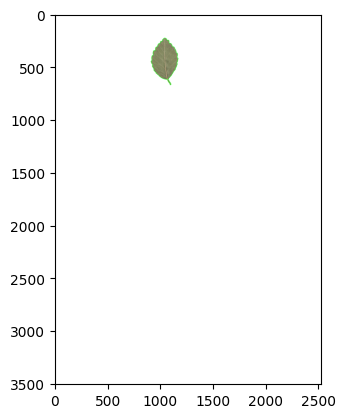

In [ ]:
mask = np.zeros(elm_img_rgb.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, cs, 2, 255, cv2.FILLED)
# Инвертирование маски: контуры черные, все остальное - белое
mask_inv = cv2.bitwise_not(mask)

# Сохраняем исходное изображение внутри контуров
image_masked = cv2.bitwise_and(elm_img_rgb, elm_img_rgb, mask=mask)
# Создание белого фона
white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

# Добавляем белый фон за пределами контуров
background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

# Объединяем контуры с исходным изображением и белый фон
final_result = cv2.bitwise_or(image_masked, background_masked)
plt.imshow(final_result)

In [ ]:
dst = elm_img_rgb.copy()

In [ ]:
x, y = np.where(thresh1 != 0)
pts = zip(x, y)
for pt in pts:
   dst[pt] = (255, 255, 255)

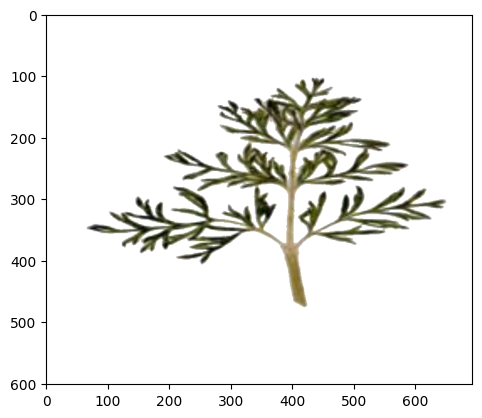

In [ ]:
plt.imshow(dst)

In [ ]:
cv2.imwrite('turcz_bin.jpg', cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

True

In [ ]:
print(len(contours))

26


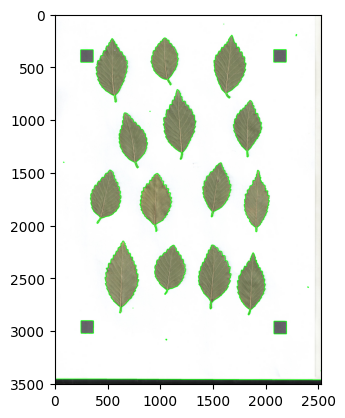

In [ ]:
plt.imshow(cv2.drawContours(elm_img_rgb, contours, -1, (0,255,0), 5))

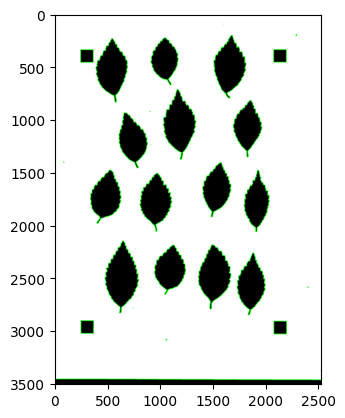

In [ ]:
plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 5))

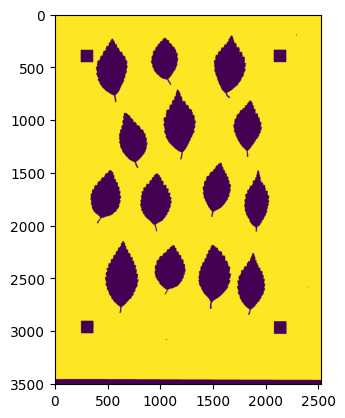

In [ ]:
plt.imshow(eroded_image)

In [ ]:
contours, hierarchy = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

[((737, 2785, 3, 3), 4), ((1597, 94, 3, 3), 25), ((897, 920, 6, 5), 16), ((79, 1402, 8, 6), 14), ((2281, 193, 9, 16), 24), ((1048, 3080, 11, 11), 1), ((2391, 2584, 11, 8), 5), ((245, 2905, 121, 122), 3), ((242, 338, 122, 121), 19), ((2069, 337, 122, 121), 20), ((2071, 2910, 123, 122), 2), ((1790, 1479, 241, 586), 11), ((907, 225, 261, 449), 22), ((1397, 1408, 270, 517), 13), ((1722, 2261, 271, 592), 6), ((605, 935, 272, 526), 15), ((1687, 818, 272, 538), 17), ((334, 1477, 292, 508), 12), ((943, 2189, 295, 470), 7), ((804, 1509, 303, 554), 10), ((386, 232, 303, 604), 21), ((1503, 200, 306, 599), 23), ((1357, 2188, 311, 608), 8), ((1024, 715, 313, 664), 18), ((472, 2150, 322, 684), 9), ((0, 0, 2528, 3467), 0)]


((0, 0, 2528, 3467), 0)

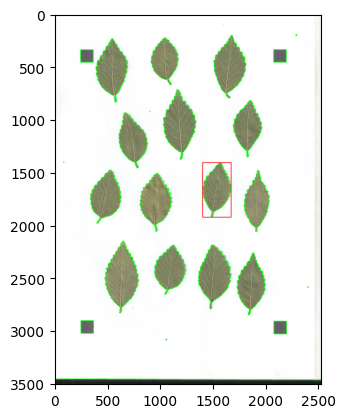

In [ ]:
plt.imshow(elm_img_rgb)

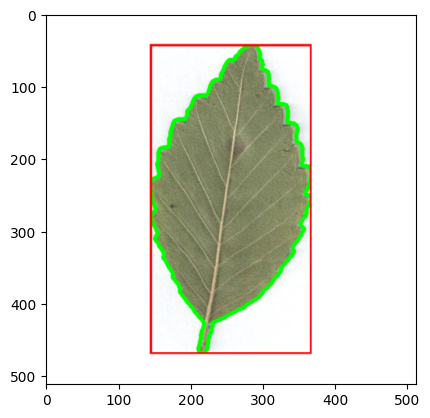

In [ ]:
import cv2
import numpy as np

def crop_and_resize(img, x1, y1, x2, y2, output_size=(512, 512), padding=100):
    """
    Вырезает кусок изображения по координатам, переносит его на белый фон,
    и применяет resize до указанного размера.

    Args:
        image_path: Путь к изображению.
        x1: Координата X верхнего левого угла вырезаемой области.
        y1: Координата Y верхнего левого угла вырезаемой области.
        x2: Координата X нижнего правого угла вырезаемой области.
        y2: Координата Y нижнего правого угла вырезаемой области.
        output_size: Желаемый размер выходного изображения (ширина, высота).

    Returns:
        NumPy массив, представляющий обработанное изображение. Возвращает None в случае ошибки.
    """

    # 2. Вырезание области (ROI - Region of Interest)
    cropped_img = img[y1:y2, x1:x2]

    # 3. Создание белого фона (квадратного)
    height, width = cropped_img.shape[:2]
    max_dim = max(height, width) + padding  # Определяем максимальную сторону для квадратного фона
    white_background = np.full((max_dim, max_dim, 3), 255, dtype=np.uint8) #Создаем белый квадрат

    # 4. Размещение вырезанной области на белом фоне (центрирование)
    x_offset = (max_dim - width) // 2
    y_offset = (max_dim - height) // 2
    white_background[y_offset:y_offset+height, x_offset:x_offset+width] = cropped_img

    # 5. Изменение размера изображения
    resized_img = cv2.resize(white_background, output_size, interpolation=cv2.INTER_AREA)  # Используем INTER_AREA для уменьшения

    return resized_img

# Пример использования:
image_path = "your_image.jpg"  # Замените на путь к вашему изображению
x1, y1 = 100, 50  # Верхний левый угол вырезаемой области
x2, y2 = 300, 200  # Нижний правый угол вырезаемой области
output_size = (512, 512)

processed_image = crop_and_resize(elm_img_rgb, 1397, 1408, 1397+270, 1408+517, output_size)
plt.imshow(processed_image)

In [ ]:
cv2.rectangle(elm_img_rgb, (1397, 1408), (1397+270, 1408+517), (255, 0, 0), 5)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[ 33,  35,  34],
        [ 31,  33,  30],
        [ 30,  32,  31],
        ...,
        [ 27,  29,  28],
        [ 27,  29,  28],
        [ 28,  30,  29]],

       [[ 38,  40,  37],
        [ 41,  43,  38],
        [ 30,  32,  29],
        ...,
        [ 29,  29,  31],
        [ 27,  27,  29],
        [ 28,  28,  30]],

       [[ 48,  50,  45],
        [ 51,  53,  48],
        [ 40,  42,  37],
        ...,
        [ 29,  29,  31],
        [ 27,  27,  29],
        [ 28,  28,  30]]

In [ ]:
len(contours)

26

In [ ]:
cp = eroded_image.copy()

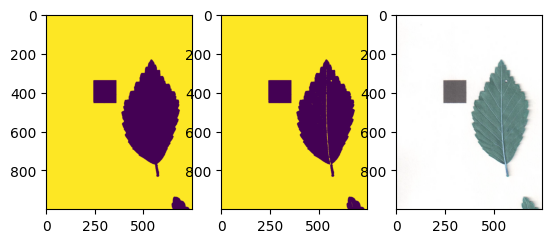

In [ ]:
figure, axes = plt.subplots(1, 3)
axes[0].imshow(cv2.drawContours(eroded_image, contours, -1, (156,255,156), 5)[0:1000, 0:750])
axes[1].imshow(thresh1[0:1000, 0:750])
axes[2].imshow(elm_img[0:1000, 0:750])

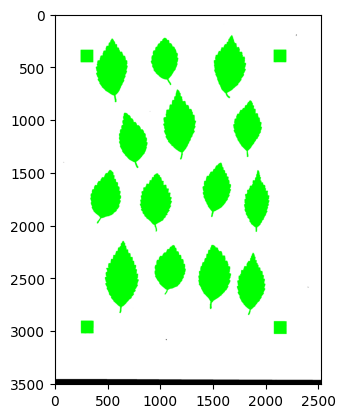

In [ ]:
plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, -1, (0,255,0), -1))

In [ ]:
import time

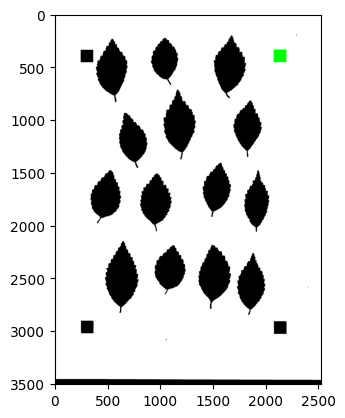

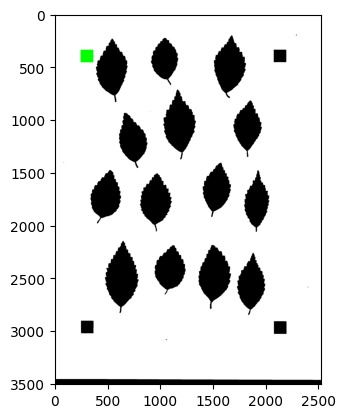

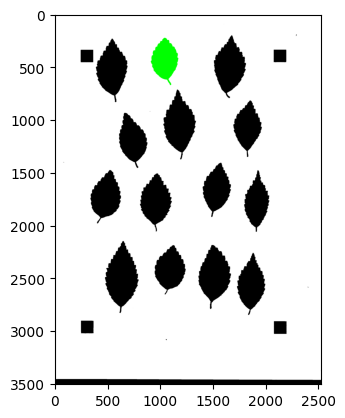

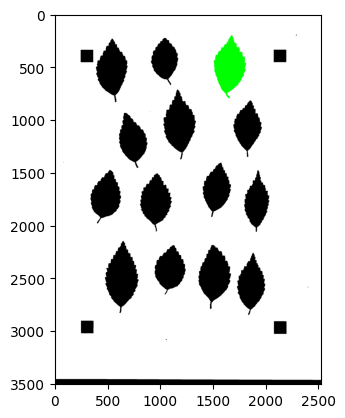

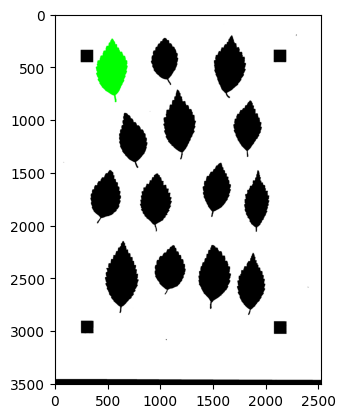

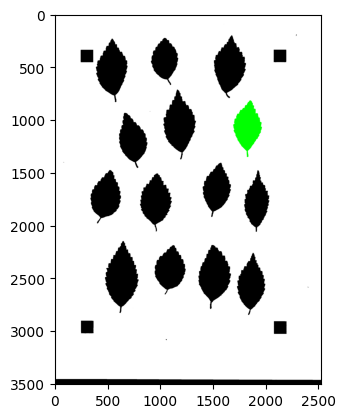

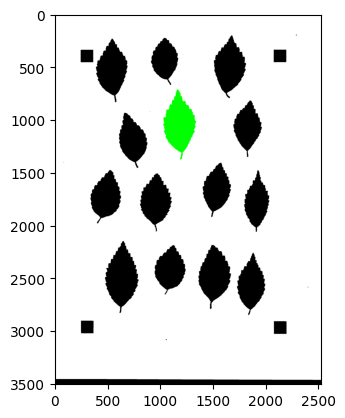

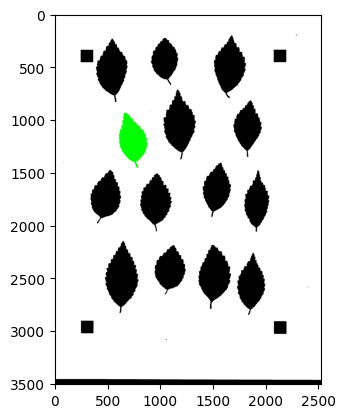

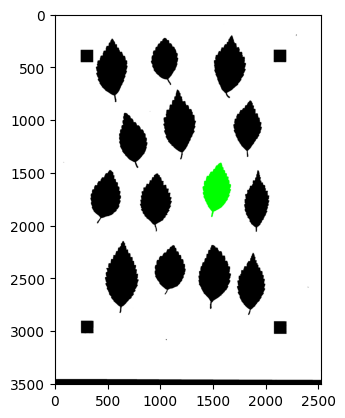

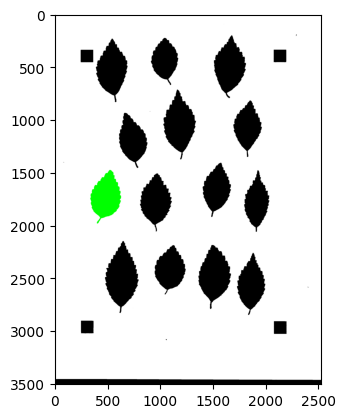

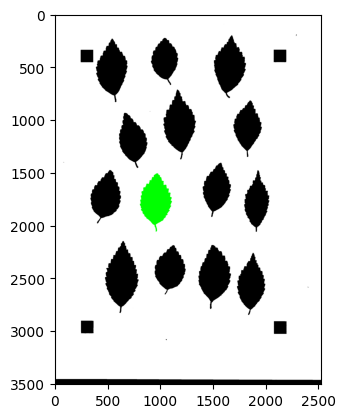

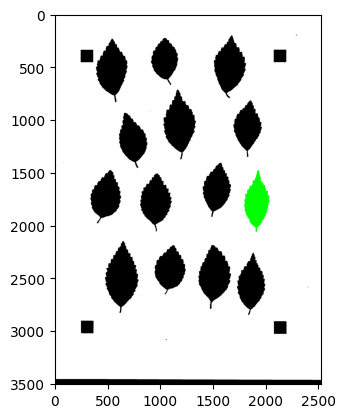

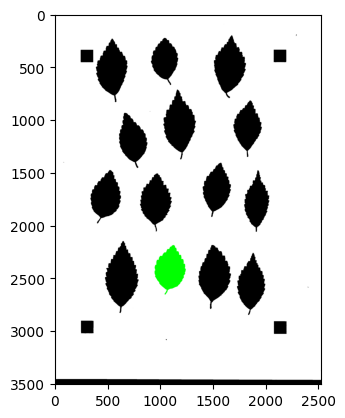

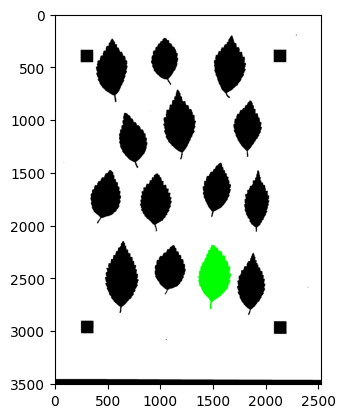

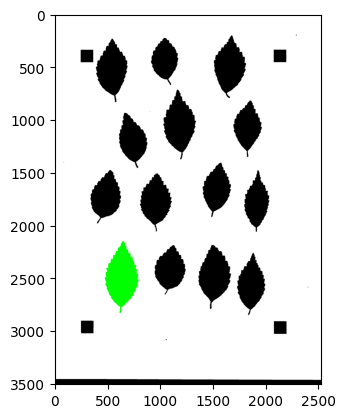

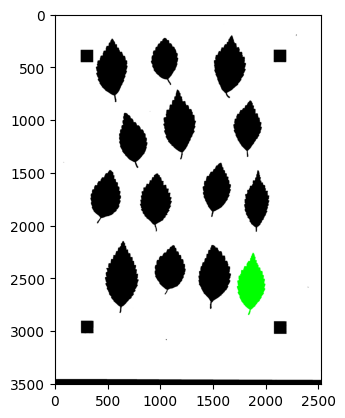

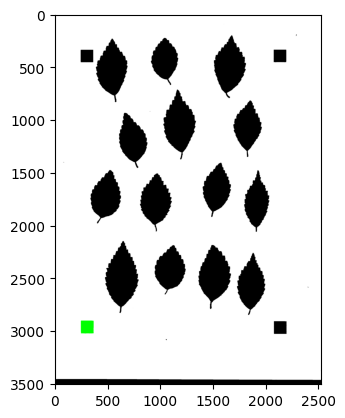

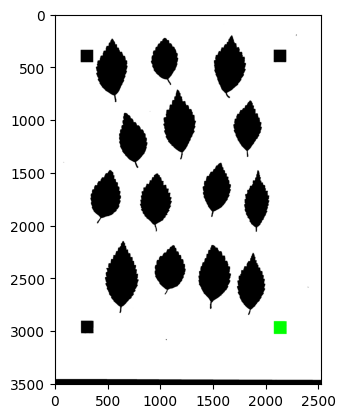

In [ ]:
for i in range(len(cs)):
  plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, i, (0,255,0), -1))
  plt.show()
  time.sleep(1)

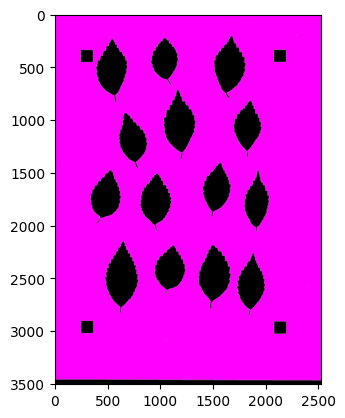

In [ ]:
 cv2.connectedComponentsWithStats(eroded_image, 4, cv2.CV_32S)

(2,
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[      0,      95,    2528,    3411, 1474007],
        [      0,       0,    2528,    3467, 7389161]], dtype=int32),
 array([[1191.32871689, 1716.34706823],
        [1277.8968952 , 1759.71187081]]))